In [1]:
import requests, re, os
from bs4 import BeautifulSoup
from string import punctuation
import pandas as pd

In [2]:
header = {"user-agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36"}
NaverMovieUrl = 'https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page='
ReviewSavingPath = os.path.join(os.getcwd(), 'CrawledNaverNewsReview/')

# Params for crawling
CurrentPageNo = 1
maxPageNo = 100
lastReviewNo = 0

In [3]:
# 불용어 처리를 위한 정규식 패턴 정의
def getRePatternList():
    patternList = dict()
    pattern = re.compile(r"[%s]{1,}" % re.escape(punctuation))  # punctuation 안의 특수문자가 두번이상 반복되는 모든 문자에 대해 패턴 정의
    patternList["SpecialChr"] = pattern

    pattern2 = re.compile(r"\s{2,}")  # 두칸짜리 공백제거
    patternList["2Whitespace"] = pattern2

    pattern3 = re.compile(r"([^ㄱ-ㅎㅏ-ㅣ가-힣0-9]+)")  # 한글이 아닌 영어 기호 제거
    patternList["NonKorean"] = pattern3

    pattern4 = re.compile(r'[A-Za-z-_]{8,}')  # 영어 (대소문자) +\-\_ 제거 (8글자 이상)
    patternList["ElimLongEng"] = pattern4

    pattern5 = re.compile(r'[0-9]')  # 숫자만 제거
    patternList["ElimNum"] = pattern5

    pattern6 = re.compile(r"\s{1,}")  # 한칸짜리 공백제거
    patternList["1Whitespace"] = pattern6

    return patternList

# 불용어처리함수(Eliminate Punctuation)
def ElimPunc(txtList, mode):
    patternList = getRePatternList()
    if mode == 'txt':
        for _ in ["SpecialChr", "1Whitespace", "2Whitespace", "NonKorean", "ElimLongEng", "ElimNum"]:
            for i in range(len(txtList)):
                txtList = patternList[_].sub(" ", txtList) 
        return txtList
    elif mode == 'none': # 아무 불용어 처리도 하지 않음. 
        return txtList
    elif mode != 'nontxt':
        txtList = re.sub(r"[\s]{2,}", " ", item.strip().replace(",", " "))
        return txtList
    else:
        print("wrong mode str passed.")

# HTTP Response를 받아오기 위한 함수
def getResponse(url, param=None, retries=3):
    resp = requests.get(url, params=param, headers=header)
    resp.raise_for_status()
    return resp

# txt파일에서 데이터를 읽기 위한 함수
def getContent(file):
    with open(file, encoding="UTF-8") as f:
        content = f.read()
    return content

In [4]:
try:  # output_path 디렉토리 존재 여부 확인 후 없으면 디렉토리 생성(makedirs)
    if not (os.path.isdir(ReviewSavingPath)):  # 디렉토리 존재여부 확인
        os.makedirs(os.path.join(ReviewSavingPath)) # 네이버 리뷰 저장을 위한 경로생성
        print("Directory has been created : ", ReviewSavingPath)
except OSError as e:
    print("Failed to create directory!!!!!")
    raise

### '뽀로로 극장판 보물섬 대모험' 리뷰 크롤링하기

In [5]:
# 정상 Response이면서 CurrentPageNo < maxPageNo인 동안만 수행
while CurrentPageNo < maxPageNo:
    print(NaverMovieUrl+str(CurrentPageNo))
    html = getResponse(NaverMovieUrl+str(CurrentPageNo))
    
    if html.status_code == 200:    
        dom = BeautifulSoup(html.text, "html.parser")
        pointList = dom.select(".list_netizen tbody > tr")
#         print(pointList) # 정상
    
        if CurrentPageNo < 2:
            pointItem = pointList[0].select("td")
            MovieName = ElimPunc(pointItem[3].select_one("a").text, 'txt')
            ReviewSavingPath = ReviewSavingPath + MovieName + '.txt'
            print(ReviewSavingPath)

        # 쓰기모드로 파일을 연 후 뒤에 계속해서 리뷰 내용 추가
        txt = open(ReviewSavingPath, 'a', encoding = "utf-8")
        
        for pointInfo in pointList:
            pointItem = [point for point in pointInfo.select("td")]
            pointID = ElimPunc(pointItem[0].text, 'none') # 리뷰의 ID
            pointScore = ElimPunc(pointItem[2].text, 'none') # 별점(0~10)
            pointMovie = ElimPunc(pointItem[3].select_one("a").text, 'none') # 리뷰대상 영화제목
            pointComment = ElimPunc(pointItem[3].contents[4], 'txt') # 관람객 리뷰 텍스트
            pointRegData = ElimPunc(pointItem[4].contents[-1], 'none') # 등록일자

            if lastReviewNo == pointID: # 중복데이터에 대한 예외처리
                continue
            else:
                txt.write("{0},{1},{2},{3},{4}\n".format(pointID, pointScore, pointMovie, pointComment, pointRegData))
        txt.close()
        lastReviewNo = pointID
        CurrentPageNo = CurrentPageNo + 1
        html = getResponse(NaverMovieUrl+str(CurrentPageNo))
    else:
        print("HTTP error")

https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=1
C:\Users\brsta\ICT_AI_AdvanceClass_NLP\NaverSentimentAnalysis\CrawledNaverNewsReview/뽀로로 극장판 보물섬 대모험.txt
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=2
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=3
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=4
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=5
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=6
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=7
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=8
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=9
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&pa

https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=90
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=91
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=92
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=93
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=94
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=95
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=96
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=97
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=98
https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=183136&target=after&page=99


### 크롤링한 영화로부터 감성분석하기

In [6]:
import os, sys
import numpy as np
import pandas as pd
from random import random
from collections import defaultdict
from konlpy.tag import Kkma, Komoran
from collections import Counter, defaultdict

In [7]:
ReviewSavingPath

'C:\\Users\\brsta\\ICT_AI_AdvanceClass_NLP\\NaverSentimentAnalysis\\CrawledNaverNewsReview/뽀로로 극장판 보물섬 대모험.txt'

In [8]:
data = pd.read_csv(ReviewSavingPath, engine='python', header=None, 
                   names=["reviewid","score", "title", "review", "date"], encoding='utf-8')
print(type(data))
data = data[data.review.notnull()] # null데이터 검사
data = data.drop_duplicates()
data.head()

<class 'pandas.core.frame.DataFrame'>


,reviewid,score,title,review,date
0,15608380,10,뽀로로 극장판 보물섬 대모험,말이필요없죠 뽀벤저스 엄청기다렸어요 ㅋ 다음시즌도 기다려봅니다 어른도 재미있는 아이...,19.05.01
1,15608335,10,뽀로로 극장판 보물섬 대모험,애들이 너무나 좋아했어용 역시 뽀로로는 아이들의 대통령,19.05.01
2,15608284,10,뽀로로 극장판 보물섬 대모험,아이들이 무서워했지만 좋아했어요,19.05.01
3,15608179,10,뽀로로 극장판 보물섬 대모험,넘 재밌게 봤네요 아이들과 공감할 수 있어서 좋았어요 옆에 애기들 부모님들이랑 같이...,19.05.01
4,15608142,8,뽀로로 극장판 보물섬 대모험,잘봤습니다 아이도 좋아했고 나름 내용도 탄탄한데 예전 뽀로로공룡섬대모험이 저는 훨씬...,19.05.01


In [9]:
data.count()

reviewid    989
score       989
title       989
review      989
date        989
dtype: int64

In [10]:
# 7점보다 높으면 positive, 반대인 경우 negative
upperBound = 7
lowerBound = 3

data = data[data["score"] < 10]
positive = data[data["score"] > upperBound]
negative = data[data["score"] < lowerBound]
len(positive), len(negative)

(219, 9)

In [11]:
positive

,reviewid,score,title,review,date
4,15608142,8,뽀로로 극장판 보물섬 대모험,잘봤습니다 아이도 좋아했고 나름 내용도 탄탄한데 예전 뽀로로공룡섬대모험이 저는 훨씬...,19.05.01
7,15607999,8,뽀로로 극장판 보물섬 대모험,점점 수준이 높아지네요,19.05.01
12,15607886,9,뽀로로 극장판 보물섬 대모험,아이랑 같이 너무재밌게봤습니다,19.05.01
15,15607830,8,뽀로로 극장판 보물섬 대모험,성인인 저는 중간 살짝 졸음이 아이는 정말 재밌게 보네요 에디는 성우가 바뀐것 같아...,19.05.01
20,15607675,8,뽀로로 극장판 보물섬 대모험,이번 극장판은 조금 지루했어요ㅠ,19.05.01
21,15607658,8,뽀로로 극장판 보물섬 대모험,아들이 좋아하고 잘보네요,19.05.01
22,15607644,8,뽀로로 극장판 보물섬 대모험,살 살 모두 좋아하네요,19.05.01
25,15607520,8,뽀로로 극장판 보물섬 대모험,아이가 좋아하네요,19.05.01
27,15607454,8,뽀로로 극장판 보물섬 대모험,딸아이 넘 재밌다 하네요,19.05.01
28,15607448,8,뽀로로 극장판 보물섬 대모험,좋아요 잼있어요 ㅎㅎㅎ,19.05.01


In [12]:
negative

,reviewid,score,title,review,date
49,15606872,1,뽀로로 극장판 보물섬 대모험,어벤져스 엔드게임 한번 더 보시는 걸 추천드립니다,19.05.01
445,15603354,1,뽀로로 극장판 보물섬 대모험,별 개도 아쉽다 도대체 어른들의 꿈과희망이랑 같이 개봉해서 꿈과희망을 파괴시키는 이...,19.05.01
489,15600285,2,뽀로로 극장판 보물섬 대모험,뽀로로 씨리즈 중 처음으로 잠들게 만듬,19.04.30
510,15599640,2,뽀로로 극장판 보물섬 대모험,그동안의 뽀로로 극장판이랑 너무 다릅니다 내용이 너무 유치해졌고 스토리도 별로이고 ...,19.04.30
512,15599604,1,뽀로로 극장판 보물섬 대모험,관객수 만 예상해본다 뽀로로 성공했을 때 연령층을 높여 수준 높은 애니를 만들며...,19.04.30
677,15592055,1,뽀로로 극장판 보물섬 대모험,,19.04.29
994,15586361,1,뽀로로 극장판 보물섬 대모험,뽀로로 중 제일 재미없음 스토리도없고,19.04.28
1006,15586178,2,뽀로로 극장판 보물섬 대모험,전편보다 아이들이 집중을 못하네요,19.04.28
1036,15585935,1,뽀로로 극장판 보물섬 대모험,구린 그래픽과 발로쓴 시나리오,19.04.28


In [13]:
def getTheta(topic, docName):
    return docTopicDistribution[docName][topic] + a

def getPhi(term, topic):
    return (topicTermDistribution[topic][term] + b) / (topicTermCount[topic] + V * b)

def topicAssignment(docName, term, topic):
    return getTheta(topic, docName) * getPhi(term, topic)

def collapsedGibbsSampling(docName, term):
    return randomSampling([topicAssignment(docName, term, topic) for topic in range(K)])

def randomSampling(topicProbabilites):
    topicSum = sum(topicProbabilites)
    
    rnd = topicSum * random()

    for i, p in enumerate(topicProbabilites):
        rnd -= p
        
        if rnd <= 0:
            return i

In [14]:
ma = Kkma()

documents = defaultdict(list)
vocabulary = list()

for i, review in zip(data.index, data.review):
    for term in [_ for _ in ma.nouns(review) if 1 < len(_) < 8]:
        documents[i].append(term)
        vocabulary.extend(documents[i])
        
vocabulary = list(set(vocabulary))

In [21]:
K = 5 # 분석할 토픽 개수

M = len(documents)
V = len(vocabulary)

a = 1.0
b = 0.1

docTermCount = defaultdict(int)
topicTermCount = defaultdict(int)
docTopicDistribution = defaultdict(lambda: defaultdict(int))
topicTermDistribution = defaultdict(lambda: defaultdict(int))
termTopicAssignmentMatrix = defaultdict(lambda: defaultdict(int))

In [22]:
from random import randrange

for docName, termList in documents.items():
    for termIdx, term in enumerate(termList):
        topic = randrange(K)
        
        docTermCount[docName] += 1
        topicTermCount[topic] += 1
        docTopicDistribution[docName][topic] += 1
        topicTermDistribution[topic][term] += 1
        
        termTopicAssignmentMatrix[docName][termIdx] = topic

In [23]:
iteration = 1000

for _ in range(iteration):
    for docName, termList in documents.items():
        for termIdx, term in enumerate(termList):
            topic = termTopicAssignmentMatrix[docName][termIdx]
            
            docTermCount[docName] -= 1
            topicTermCount[topic] -= 1
            docTopicDistribution[docName][topic] -= 1
            topicTermDistribution[topic][term] -= 1
            
            topic = collapsedGibbsSampling(docName, term)
            termTopicAssignmentMatrix[docName][termIdx] = topic
            
            docTermCount[docName] += 1
            topicTermCount[topic] += 1
            docTopicDistribution[docName][topic] += 1
            topicTermDistribution[topic][term] += 1
    if _%100 == 0:
        print("{0:2.0f}%".format(_/10))

 0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

path = "C:/windows/fonts/HMKMRHD.ttf"

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["font.family"] = "AppleGothic"

def drawCloud(words, title):
    wc = WordCloud(font_path=path, max_words=30, background_color="white")
    wc.generate_from_frequencies(words)
    plt.imshow(wc.to_array())
    plt.title(title)
    plt.axis("off")
    plt.show()

[('아이', 19), ('뽀로로', 14), ('집중', 6), ('뽀통', 5), ('애기', 5), ('우리', 4), ('뽀통령', 4), ('나이', 3), ('볼만', 2), ('나들이', 2), ('이야기', 2), ('봣어', 2), ('공룡', 2), ('수준', 2), ('이상', 2), ('오랜만', 2), ('정도', 2), ('최고', 2), ('조금', 2), ('딸램', 1)]


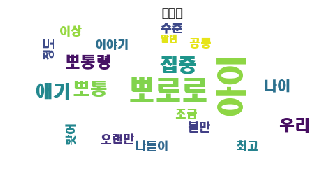

[('아이', 16), ('딸아이', 5), ('어른', 5), ('중간', 5), ('영화', 4), ('보기', 4), ('추천', 3), ('게임', 3), ('엔드게임', 3), ('살아이', 3), ('등장', 2), ('감동', 2), ('모드', 2), ('목소리', 2), ('예전', 2), ('공룡섬', 2), ('성우', 2), ('져스', 2), ('저희', 2), ('사랑', 2)]


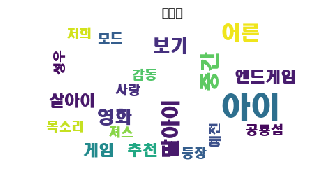

[('아이', 70), ('집중', 21), ('살아이', 3), ('처음', 3), ('생각', 3), ('행복', 3), ('시간', 3), ('기대', 3), ('아이둘', 2), ('데이트', 2), ('유아', 2), ('스릴', 2), ('성인', 1), ('졸음', 1), ('영화', 1), ('남자', 1), ('예매', 1), ('예고편도', 1), ('나이제한', 1), ('덕분', 1)]


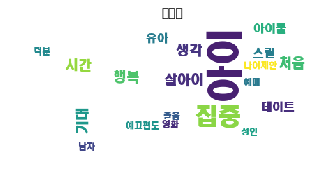

[('뽀로', 14), ('영화', 13), ('아기', 9), ('어린이', 5), ('개월', 4), ('집중', 3), ('시작', 3), ('어른', 3), ('엔드', 3), ('엄마', 3), ('시시해', 2), ('완전', 2), ('애기', 2), ('자리', 2), ('영화중', 2), ('시해', 2), ('살이', 2), ('필요', 2), ('친구', 2), ('예고', 2)]


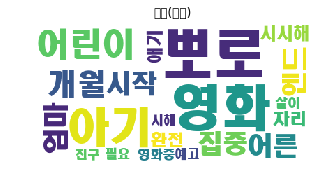

[('극장', 19), ('뽀로', 13), ('극장판', 10), ('내용', 9), ('아들', 8), ('스토리', 6), ('이번', 5), ('노래', 5), ('재미', 5), ('시리즈', 4), ('영화관', 3), ('소리', 3), ('모험', 3), ('수준', 2), ('큰아이', 2), ('저번', 2), ('오늘', 2), ('이랑', 2), ('대통령', 2), ('관람', 2)]


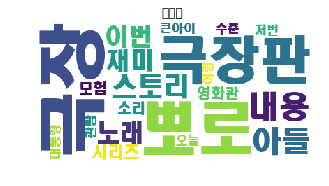

In [25]:
topicTitle = ["캐릭터", "스토리", "감상평", "극장(환경)", "시리즈"]

for topic in range(K):
    topicWords = sorted(topicTermDistribution[topic].items(), key=lambda x:x[1], reverse=True)[:20]
    print(topicWords)
    drawCloud(dict(topicWords), topicTitle[topic])